Now that we know how word embedding works, we'll apply it to a supervised problem of sentiment analysis. The idea is to classify the comments left by users according to the number of stars they gave the Disneyland resort park in their reviews.

In [94]:
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [95]:
# Import dataset with Pandas
dataset = pd.read_csv("https://go.aws/314bBDq", encoding="utf-8")
dataset.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
1,e3be4f9c9e0b9572bfb2a5f88497bb14,NaN,2,2017-09-29 17:29:00,17:29,17,Ven,NaN,NaN,2017-09,0,0
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
3,fa330e5891a1bb486c3e9bf95c098726,NaN,5,2017-09-29 15:52:00,15:52,15,Ven,NaN,NaN,2017-09,0,0
4,c1a693206aee1a2412d4bd9e45b80ec5,NaN,3,2017-09-29 15:29:00,15:29,15,Ven,NaN,NaN,2017-09,0,0


We will need the reviews in French. Filter the reviews so that they are in the right language. For this you need to find a column that gives you that information.

In [96]:
# Taking only french reviews
french_reviews = dataset[dataset.review_lang == "french"]
french_reviews.head()

,user_id,review,stars,date_format,time_of_day,hour_of_day,day_of_week,review_format,review_lang,month_year,review_len,review_nb_words
0,efb62a167fee5cf3678b24427de8e31f,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,2017-09-29 18:17:00,18:17,18,Ven,génial fabuleux exceptionnel j aimerais qu...,french,2017-09,115,19
2,1b8e5760162d867e9b9ca80f645bdc60,"Toujours aussi magic, féerique !",5,2017-09-29 16:46:00,16:46,16,Ven,toujours aussi magic féerique,french,2017-09,32,4
11,726b1a3e2664e8b075129bcd643dbf56,En vacances en région parisienne nous nous som...,2,2017-09-29 00:37:00,00:37,0,Ven,en vacances en région parisienne nous nous som...,french,2017-09,172,25
12,8a71763fbb3da7436b957681b24cc404,Tropbeaufinalpleinlesyeuxoreil,5,2017-09-29 00:16:00,00:16,0,Ven,tropbeaufinalpleinlesyeuxoreil,french,2017-09,30,1
23,ce7abd7798ee036d667c0ad84b85daa7,L'univers Disney reste merveilleux. Toutefois ...,4,2017-09-28 20:24:00,20:24,20,Jeu,l univers disney reste merveilleux toutefois ...,french,2017-09,148,23


Keep only the review & stars columns.

In [97]:
# Let's take the columns we're interested in
french_reviews = french_reviews[["review", "stars"]]
french_reviews.head()

,review,stars
0,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5
2,"Toujours aussi magic, féerique !",5
11,En vacances en région parisienne nous nous som...,2
12,Tropbeaufinalpleinlesyeuxoreil,5
23,L'univers Disney reste merveilleux. Toutefois ...,4


# Preprocessing

We will now go through a preprocessing phase. The goal is to clean up the character strings and encode the words so they are represented as integers.

Use the command: !python -m spacy download fr_core_news_md to download all language elements related to the French language

In [98]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 12.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Load now fr_core_news_md into a variable called nlp

In [99]:
# Import Spacy and french initialisation
import fr_core_news_md
nlp = fr_core_news_md.load()

Import french STOP_WORDS

In [100]:
# Import Stop words
from spacy.lang.fr.stop_words import STOP_WORDS

Try the nlp function on the following sentence "je la laisse, je veux la laisser, je l'ai laissée, je me suis laissé aller", and extract the lemma using a list comprehension, what happened to the words in the sentence?

In [101]:
a = nlp("je la laisse, je veux la laisser, je l'ai laissée, je me suis laissé aller")

In [102]:
doc = nlp(a)
print(doc)

je la laisse, je veux la laisser, je l'ai laissée, je me suis laissé aller


In [82]:
lemmes =[token.lemma_ for token in doc]
print(lemmes)

['je', 'le', 'laisse', ',', 'je', 'vouloir', 'le', 'laisser', ',', 'je', 'le', 'avoir', 'laisser', ',', 'je', 'me', 'être', 'laisser', 'aller']


In [103]:
[element.lemma_ for element in a]

['je',
 'le',
 'laisse',
 ',',
 'je',
 'vouloir',
 'le',
 'laisser',
 ',',
 'je',
 'le',
 'avoir',
 'laisser',
 ',',
 'je',
 'me',
 'être',
 'laisser',
 'aller']

All the words are replaced by a common representation, the reason why the word "laisse" has not been replaced by the infinitive form is that it is a homonym to the noun "laisse", lemmatization is sometimes sensitive to ambiguity.

You will now have to clean our texts in order to prepare them for training. Let's do this in three different steps :

using the command str.isalnum remove all characters from your strings that are not alphanumeric except for whitespaces, and apostrophies.

using str.replace, str.lower and str.strip replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.

using spacy, replace all tokens in your texts with lemma_ and remove all the stop words.

In [104]:
french_reviews["review_clean"] = french_reviews["review"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
french_reviews["review_clean"] = french_reviews["review_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
french_reviews["review_clean"] = french_reviews["review_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

french_reviews

KeyboardInterrupt: 

In [105]:
french_reviews = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/sentiment-analysis/french_reviews_clean.csv")

In [106]:
mask = french_reviews.review_clean.apply(lambda x: type(x)==str)
mask.value_counts()

,count
review_clean,
True,8467
False,7


In [107]:
french_reviews = french_reviews.loc[mask,:]

Using tf.keras.preprocessing.text.Tokenizer Tokenizer, process to encoding all the reviews (be careful, some reviews might have been entirely erased, try and understand why, remove those reviews)
When instanciating the tokenizer, make sure you set it up to keep only the 1000 most common words.

In [108]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(french_reviews.review_clean)
french_reviews["review_encoded"] = tokenizer.texts_to_sequences(french_reviews.review_clean)

In [109]:
french_reviews.head()

,review,stars,review_clean,review_encoded
0,"Génial, fabuleux, exceptionnel ! J'aimerais qu...",5,génial fabuleux exceptionnel aimer walt disn...,"[111, 581, 484, 196, 466, 6, 1, 1]"
1,"Toujours aussi magic, féerique !",5,magic féerique,"[332, 77]"
2,En vacances en région parisienne nous nous som...,2,vacance région parisien décider visiter parc r...,"[405, 1, 1, 807, 467, 3, 1, 1, 5, 352, 135, 3,..."
3,Tropbeaufinalpleinlesyeuxoreil,5,tropbeaufinalpleinlesyeuxoreil,[1]
4,L'univers Disney reste merveilleux. Toutefois ...,4,univers disney merveilleux regrette falloir dé...,"[378, 6, 93, 666, 65, 1, 114, 166, 1, 112, 667..."


Try and convert your texts and labels into a tensor slice dataset using tf.data.Dataset.from_tensor_slices (it should fail giving this error : ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).)

In [110]:
full_ds = tf.data.Dataset.from_tensor_slices((french_reviews.review_encoded, french_reviews.stars.values-1))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

This is perfectly normal, Tensorflow is incapable as of now to create a tensor dataset based on lists, we will have to store all of our encoded texts into a single numpy array before creating the tensorflow dataset. The problem is that not all our sequences are the same length, this is where the tf.keras.preprocessing.sequence.pad_sequences comes in handy, it will add zero padding at the beginning (padding="pre") or at the end (padding="post") of your sequences so they all have equal length.

In [111]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(french_reviews.review_encoded, padding="post")

Do a train_test_split of your data (keep about 70% in the train). For this you may use sklearn.model_selection.train_test_split.

In [113]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,french_reviews.stars, test_size=0.3)

Now that your sequences are padded create the tensor dataset for the training, and validation set. The target variable is qualitative ordinal, this means you may treat the sentiment analysis problem as a regression problem. However you may choose to adopt a classification approach, in this case make sure you modify the stars column so that the scores go from 0 to 4 instead of 1 to 5 to avoid errors when setting up your model's architecture and the loss function. (Since this is a multiple classification problem, we will use SparseCategoricalCrossentropy which assumes that the first label is 0)
The solution will first use the regression approach.

In [114]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

Once you have done this you may use .shuffle on the train set, and .batchon both sets to organise them by batches of 64 observations.

shuffle documentation

batch documentation

In [115]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

Look at a batch of data

In [116]:
 # Regardons un batch
for review, star in train_batch.take(1):
  print(review, star)

tf.Tensor(
[[ 35 138   1 ...   0   0   0]
 [ 19 216  27 ...   0   0   0]
 [ 22 143   1 ...   0   0   0]
 ...
 [  3  39 111 ...   0   0   0]
 [ 38 540 993 ...   0   0   0]
 [ 72 218  49 ...   0   0   0]], shape=(64, 443), dtype=int32) tf.Tensor(
[5 5 5 4 5 1 5 5 1 5 5 5 4 5 4 5 4 3 3 5 3 3 5 5 5 3 4 5 4 5 5 4 3 4 5 4 5
 3 5 4 5 5 1 5 5 3 5 5 5 5 5 5 5 4 5 2 5 5 3 5 5 4 5 5], shape=(64,), dtype=int64)


# Modeling

Let's create a model in order to train an embedding!

Follow a similar architecture to the one we used in the code embedding demonstration.

In [117]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[review.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [118]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 443, 8)              │           8,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,169 (31.91 KB)

 Trainable params: 8,169 (31.91 KB)

 Non-trainable params: 0 (0.00 B)

Compile your model with the correct loss function, and the Adam optimizer.

In [119]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Fit your model on 20 epochs with weights to penalize too frequent notes.

In [120]:
history = model.fit(train_batch,
                    epochs=20,
                    validation_data=val_batch)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.4784 - mean_absolute_error: 1.9960 - val_loss: 1.3662 - val_mean_absolute_error: 0.9485
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4117 - mean_absolute_error: 0.9450 - val_loss: 1.3621 - val_mean_absolute_error: 0.9497
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3841 - mean_absolute_error: 0.9405 - val_loss: 1.3669 - val_mean_absolute_error: 0.9622
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4169 - mean_absolute_error: 0.9527 - val_loss: 1.3464 - val_mean_absolute_error: 0.9248
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3784 - mean_absolute_error: 0.9290 - val_loss: 1.3402 - val_mean_absolute_error: 0.9298
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4909 - mean_absolute_error: 0.9714 - val_loss: 1.3359 - val_mean_absolute_error: 0.9158
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3860 - mean_absolute_error: 0.9342 - val_loss: 1.34

# Evaluation

Create a graph showing your loss in relation to the number of epochs.

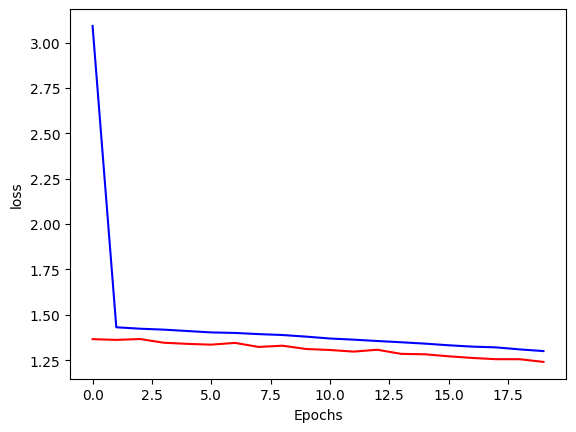

In [121]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

Create a graph showing your accuracy in relation to the number of epochs.

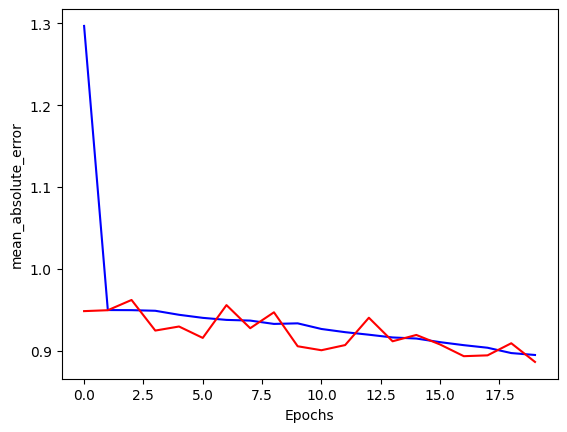

In [122]:
# Visualization of accuracy training
plt.plot(history.history["mean_absolute_error"], color="b")
plt.plot(history.history["val_mean_absolute_error"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

Write to file the weights on the embedding layer and the 1000 most common words registered by the tokenizer. You can help yourself to the code in the code embedding demonstration.

In [123]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "/content/logs/embed"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()